## Exploratory Data Analysis

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("List available databases and tables").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-05 21:26:50,979 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-05 21:26:53,966 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[Database(name='2023_11_01', description='FactSet data snapshot for 2023_11_01', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_01'),
 Database(name='2023_11_02', description='FactSet data snapshot for 2023_11_02', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_02'),
 Database(name='2023_11_03', description='FactSet data snapshot for 2023_11_03', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_03'),
 Database(name='2023_11_14', description='FactSet data snapshot for 2023_11_14', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_14'),
 Database(name='2023_11_19', description='FactSet data snapshot for 2023_11_19', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_19'),
 Database(name='2023_11_22', description='FactSet data snapshot for 2023_11_22', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_22'),
 Database(name='2024_01_25', description='FactSet da

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")


DataFrame[]

#### Helper Functions

In [3]:
from pyspark.sql.functions import when
from datetime import datetime, timedelta

def get_all_stocks_df():
    query = f"""SELECT s.ticker_region, s.fsym_id FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")"""
    df = spark.sql(query)
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    return df


def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id AS fsym_id2, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                WHERE a.date > '2000-01-01'
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    q_df = q_df.drop('date', 'adjdate', 'fsym_id2', 'fsym_id')
    num_rows = q_df.count()
    column_types = q_df.dtypes
    good_cols = []
    selected_columns = [F.col(c) for c, c_type in zip(q_df.columns, column_types) if c_type[1] == 'double']
    q_df = q_df.select(selected_columns)
    count_df = q_df.select( [(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c))/num_rows).alias(c) for c in q_df.columns])
    count_dict = count_df.first().asDict()
    filtered_keys = [key for key, value in count_dict.items() if value <= 0.25]
    return filtered_keys
#     for c, c_type in zip(q_df.columns, column_types):
#         if c_type[1] == 'double':
#             null_count = F.sum(F.when(F.isnan(F.col(c)) | F.col(c).isNull(), 1).otherwise(0))
#             null_pct = (null_count / num_rows).alias(f"{c}_null_pct")
#             q_df_agg = q_df.agg(null_pct)
#             actual_pct = q_df_agg.collect()[0][0]
#             if actual_pct < 0.25:
#                 good_cols.append(c)
            
#     return good_cols


def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])



In [4]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols, get_tabular_dataset_qf
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer

def plot_nulls(df):
    null_counts = df.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns])
    null_counts_pd = null_counts.toPandas().transpose()
    null_counts_pd.columns = ['null_percentage']

    # Plot the bar chart
    null_counts_pd.plot(kind='bar', legend=False, figsize=(20, 6))
    plt.title('Percentage of Null Values in Each Column')
    plt.ylabel('Percentage of Null Values')
    plt.xlabel('Columns')
    plt.show()
    
def plot_nulls_per_year(df):
    # Extract year from the date_column
    df = df.withColumn('Year', F.year('date'))
    
    # Group by year and sum null values for each column
    nulls_per_year = df.groupBy('Year').agg(*[
        (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns
    ]).toPandas()

    # Plot
    nulls_per_year.plot(kind='bar', x='Year', figsize=(20, 6))
    plt.title('Total Null Values per Year')
    plt.ylabel('Total Null Values')
    plt.xlabel('Year')
    plt.show()



def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset_qf(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)
    # df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)

    
    return df

def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

df = get_df('imploded_stocks_price.csv', all_feats=True, imploded_only=False, prediction=False)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-02-05 21:27:29,834 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_assets_com_eq', 'ff_assets_eq', 'ff_assets_gr', 'ff_bps_gr', 'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_sales', 'ff_com_eq_gr', 'ff_com_eq_tcap', 'ff_debt_com_eq', 'ff_debt_entrpr_val', 'ff_debt_eq', 'ff_debt_lt_cf', 'ff_debt_st_x_curr_port', 'ff_dil_adj', 'ff_earn_yld', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_free_ps_cf', 'ff_inc_adj', 'ff_inc_sund', 'ff_int_exp_oth', 'ff_invest_cap', 'ff_invest_lt', 'ff_ltd_com_eq', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_basic_beft_xord', 'ff_net_inc_bef_xord_gr', 'ff_net_inc_dil', 'ff_net_inc_dil_aft_xord', 'ff_non_oper_exp', 'ff_oper_inc_aft_unusual', 'ff_oper_inc_gr', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_roa_ptx', 'ff_roce', 'ff_roic', 'ff_sales_gr', 'ff_sales_ps_gr', 'ff_tcap_assets', 'ff_tot_debt_tcap_std', 'ff_ut_gross_inc', 'ff_ut_operation_exp', 'ff_wkcap', 'ff_wkcap_pct', 'ff_xord', 'ff_xord_di

In [5]:
df=df.toPandas()
print(len(df[df['label']==1]))

593


In [6]:
# groups = df.groupby('fsym_id')
# for fsym_id, group_data in groups:
#     if group_data['label'].sum() == 1:
#         print(f"fsym_id: {fsym_id}")
#         print(group_data[['fsym_id', 'date', 'label', 'label2']])

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_tab.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
               
df=correlation_matrix(df)
# df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
ff_assets_com_eq - ff_assets_eq: 0.9221667001250415
ff_assets_com_eq - ff_debt_com_eq: 0.8031880760546074
ff_assets_com_eq - ff_debt_eq: 0.7578387152977408
ff_assets_com_eq - ff_fix_assets_com_eq: 0.7585668862041025
ff_assets_com_eq - ff_ltd_com_eq: 0.7835837289856755
ff_assets_eq - ff_debt_com_eq: 0.8110888148264611
ff_assets_eq - ff_debt_eq: 0.9744900520306521
ff_assets_eq - ff_fix_assets_com_eq: 0.7982392735794281
ff_assets_eq - ff_ltd_com_eq: 0.7963438015130555
ff_assets_gr - ff_com_eq_gr: 0.8774939894682517
ff_assets_gr - ff_sales_gr: 0.9787031708343461
ff_capex_assets - ff_oper_inc_tcap: 0.999992191316587
ff_capex_ps_cf - ff_eps_basic_gr: 0.9714446718046087
ff_capex_ps_cf - ff_free_ps_cf: 0.9880326238225863
ff_capex_ps_cf - ff_eps_dil_gr: 0.9714485790970641
ff_com_eq_tcap - ff_tot_debt_tcap_std: 0.9953152328758681
ff_com_eq_tcap - ff_wkcap_pct: 0.9787501960750491
ff_debt_com_eq - ff_debt_eq: 0.986310903995123

In [8]:
# print(len(df[df['label']==1]))

In [9]:
df.columns

Index(['fsym_id', 'date', 'ff_assets_com_eq', 'ff_assets_gr', 'ff_bps_gr',
       'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_div_cf', 'ff_cash_roce',
       'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val', 'ff_debt_lt_cf',
       'ff_debt_st_x_curr_port', 'ff_dil_adj', 'ff_earn_yld',
       'ff_entrpr_val_sales', 'ff_inc_adj', 'ff_inc_sund', 'ff_int_exp_oth',
       'ff_invest_cap', 'ff_invest_lt', 'ff_ltd_tcap', 'ff_min_int_tcap',
       'ff_mkt_val_gr', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_bef_xord_gr',
       'ff_non_oper_exp', 'ff_oper_ps_net_cf', 'ff_pfd_stk_tcap', 'ff_roa_ptx',
       'ff_roce', 'ff_roic', 'ff_sales_ps_gr', 'ff_tcap_assets', 'ff_xord',
       'ff_std_debt', 'ff_tang_assets_debt', 'ff_bk_oper_inc_oth',
       'ff_bk_oper_inc_tot', 'ff_cf_roic', 'ff_div_yld', 'ff_liabs_lease',
       'GDP', 'Unemployment_Rate'],
      dtype='object')

In [10]:
# feats = df.columns[2:-1]
feats = df.columns[2:]
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))

In [10]:
# df.drop('Implosion_Start_Date', axis=1, inplace=True)

In [11]:
df.head(10)

,fsym_id,date,ff_assets_com_eq,ff_assets_gr,ff_bps_gr,ff_capex_assets,ff_capex_ps_cf,ff_cash_div_cf,ff_cash_roce,ff_cf_sales,...,ff_xord,ff_std_debt,ff_tang_assets_debt,ff_bk_oper_inc_oth,ff_bk_oper_inc_tot,ff_cf_roic,ff_div_yld,ff_liabs_lease,GDP,Unemployment_Rate
0,B00FG1-R,2014-03-31,1.006164,6.941630,42.755522,2.918292,0.040663,0.000000,149.850206,54.927969,...,0.0,0.000000,128.453561,0.0,0.0,21.476737,9.04872,0.0,0.006058,5.6
1,B00FG1-R,2014-06-30,7.947306,6.941630,42.755522,2.918292,0.085351,7198.072711,149.850206,58.673863,...,0.0,0.000000,116.030667,0.0,0.0,21.476737,9.04872,0.0,0.006058,5.6
2,B00FG1-R,2014-09-30,7.947306,6.941630,42.755522,2.918292,0.777880,1793.051823,149.850206,53.004612,...,0.0,0.000000,88.900000,0.0,0.0,21.476737,9.04872,0.0,0.006058,5.6
3,B00FG1-R,2014-12-31,7.947306,6.941630,42.755522,11.984993,0.568918,1752.469136,149.850206,30.259303,...,0.0,0.000000,77.245294,0.0,0.0,21.476737,9.04872,0.0,0.006058,5.6
4,B00FG1-R,2015-03-31,7.947306,1210.946360,-453.765614,11.419992,0.000515,56.551330,149.850206,62.973990,...,0.0,0.000000,78.877843,0.0,0.0,12.438389,3.49218,0.0,0.001821,5.0
5,B00FG1-R,2015-06-30,7.947306,20.015973,-522.564054,10.396011,0.006026,530.536190,149.850206,67.875989,...,0.0,0.000000,68.632495,0.0,0.0,12.660801,4.76389,0.0,0.001821,5.0
6,B00FG1-R,2015-09-30,7.947306,20.169146,-281.606764,4.546495,0.028012,55.502330,149.850206,62.488539,...,0.0,0.000000,71.079842,0.0,0.0,17.225828,7.83517,0.0,0.001821,5.0
7,B00FG1-R,2015-12-31,7.947306,7.348883,-48.051855,0.483800,0.025150,64.834284,149.850206,56.856806,...,0.0,0.000000,70.526570,0.0,0.0,19.546902,6.74157,0.0,0.001821,5.0
8,B00FG1-R,2016-03-31,7.947306,7.781205,-54.727611,0.569216,0.012767,67.074842,149.850206,59.881255,...,0.0,0.000000,72.256182,0.0,0.0,21.404235,8.06794,0.0,0.010414,4.7
9,B00FG1-R,2016-06-30,7.947306,9.770063,41.140026,0.848703,0.043794,78.941295,149.850206,51.154726,...,0.0,23.800631,80.334313,0.0,0.0,23.305352,6.90704,0.0,0.010414,4.7


In [30]:
# %%capture
# import warnings
# warnings.filterwarnings("ignore")
import tsfel

def feature_extraction_tsfel(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df = df.set_index('date')

    print("retrieving features...")
    cfg = tsfel.get_features_by_domain("statistical")
    print("features retrieved")
    
    result_dfs = []
    for fsym_id, group_df in df.groupby(['fsym_id', 'year']):
        # Exclude 'fsym_id' column from group_df
        non_zero_cols = group_df.columns[(group_df != 0).any()]
        group_df = group_df[non_zero_cols]

        if not group_df.empty:
            print("not empty")
            # try:
            print(group_df.head())
            X = tsfel.time_series_features_extractor(cfg, group_df.drop(['fsym_id', 'year'], axis=1), verbose=0)
            X['fsym_id'] = group_df['fsym_id'].iloc[0]
            X['year'] = group_df['year'].iloc[0]
            print(X.head())
            result_dfs.append(X)
            # except ValueError:
            #     print("error caught")
            #     continue
    
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result

# df2 = feature_extraction_tsfel(df)

retrieving features...
features retrieved
not empty
             fsym_id  ff_assets_com_eq  ff_assets_gr  ff_bps_gr  \
date                                                              
2014-03-31  B00FG1-R          1.006164       6.94163  42.755522   
2014-06-30  B00FG1-R          7.947306       6.94163  42.755522   
2014-09-30  B00FG1-R          7.947306       6.94163  42.755522   
2014-12-31  B00FG1-R          7.947306       6.94163  42.755522   

            ff_capex_assets  ff_capex_ps_cf  ff_cash_div_cf  ff_cash_roce  \
date                                                                        
2014-03-31         2.918292        0.040663        0.000000    149.850206   
2014-06-30         2.918292        0.085351     7198.072711    149.850206   
2014-09-30         2.918292        0.777880     1793.051823    149.850206   
2014-12-31        11.984993        0.568918     1752.469136    149.850206   

            ff_cf_sales  ff_com_eq_tcap  ...     ff_roce    ff_roic  \
date       

ValueError: zero-size array to reduction operation maximum which has no identity

In [18]:
print(len(df2))

2980


In [14]:
# def convert_to_prediction(df):
#     df_temp = spark.createDataFrame(df)
#     ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
#     df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
#     df_temp= df_temp.filter(F.col('label').isNotNull())
#     return df_temp.toPandas()

# df = convert_to_prediction(df)

KeyboardInterrupt: 

In [14]:
print(len(df))

103863


In [15]:
rows_with_null = df[df.isnull().any(axis=1)]
print(rows_with_null)

         fsym_id        date  ff_assets_com_eq  ff_assets_gr  \
19      BW85Z6-R  2002-06-30          1.758864    -14.634628   
20      BW85Z6-R  2001-06-30          1.744019      9.876688   
21      BW85Z6-R  2000-06-30          1.186599     15.298261   
44      C9XQRP-R  2021-10-31          1.586588      1.990700   
45      C9XQRP-R  2020-10-31          1.603894      4.023317   
...          ...         ...               ...           ...   
103828  V4QFTG-R  2006-12-31          1.187362     -4.984642   
103835  WV6YVV-R  2009-03-31          2.367615   1171.445773   
103836  WV6YVV-R  2007-12-31          1.307401      5.176288   
103837  WV6YVV-R  2006-12-31          1.321849     26.031245   
103838  WZNHG6-R  2021-12-31          1.035829      0.735243   

        ff_assets_oth_tot  ff_assets_per_emp  ff_bps_gr  ff_capex_assets  \
19               0.000000           0.564426 -23.148107         5.782815   
20               1.688500           0.595847 -27.838054         5.640216   
21 

In [16]:
df.isnull().sum()

fsym_id                     0
date                        0
ff_assets_com_eq          365
ff_assets_gr               22
ff_assets_oth_tot         201
ff_assets_per_emp        4552
ff_bps_gr                 175
ff_capex_assets           763
ff_cash_div_cf            794
ff_cash_roce             1299
ff_cf_ps_gr              2467
ff_cf_sales              3426
ff_com_eq_tcap             37
ff_debt_entrpr_val       1206
ff_dfd_tax_assets_lt        0
ff_dil_adj                 94
ff_div_yld               1392
ff_earn_yld              1222
ff_ebit_oper_roa        13774
ff_entrpr_val_sales      4344
ff_for_assets_pct        7278
ff_for_sales_pct         5329
ff_gross_cf_debt         2157
ff_inc_adj                  0
ff_inc_sund                 0
ff_invest_st_tot        11304
ff_ltd_tcap                38
ff_min_int_tcap            42
ff_net_inc_per_emp       4561
ff_non_oper_exp           392
ff_oper_cf_fix_chrg      4410
ff_oper_inc_tcap           54
ff_oper_ps_net_cf        1959
ff_reinves

In [17]:
df3 = df.drop(['ff_cf_sales', 'ff_oper_ps_net_cf', 'ff_invest_st_tot', 'ff_ebit_oper_roa', 'ff_for_assets_pct' ], axis=1)
print(len(df3))
df4 = df3.dropna()
print(len(df4))

103863
90032


In [18]:
print(len(df))
print(len(df[df['label']==1]))
# df=df.dropna()
# print(len(df))
df_null = df3.dropna()
print(len(df_null))
print(len(df_null[df_null['label']==1]))

103863
589
90032
384


In [19]:
df = df.drop(['ff_cf_sales', 'ff_oper_ps_net_cf', 'ff_invest_st_tot', 'ff_ebit_oper_roa', 'ff_for_assets_pct'  ], axis=1)

In [20]:
df=df.dropna()

In [21]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce

def feature_importances(model, features):
    feature_importances = model.feature_importances_

    # print("Feature Importances:")
    # for feature, importance in zip(features, feature_importances):
    #     print(f"{feature}: {importance}")

    sorted_idx = np.argsort(feature_importances)
    sorted_features = [features[i] for i in sorted_idx]
    
    half_len = (len(sorted_idx) // 4 ) * 3 # Calculate the index for the middle point

    # Select the lowest 50% of features
    selected_features = [features[i] for i in sorted_idx[:half_len]]

    plt.figure(figsize=(20, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.show()
    return selected_features

def model_testing(df, classifier):
    seed = 42
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'label']
    X_train = df.drop(exclude_columns, axis=1)
    y_train = df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', seed=42)
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=42)
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier(seed=42)
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,500,1),
           'max_depth':hp.quniform('max_depth',5,20,1)}
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(scale_pos_weight=estimate, seed=42)
    else:
        raise ValueError("Unsupported classifier")
        
    tscv = TimeSeriesSplit(n_splits=5)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='f1')
        score = -scores.mean()
        return score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
#     initial_model = classifier_instance
#     initial_model = initial_model.fit(X_train, y_train)
#     initial_preds = pd.DataFrame()
#     print("INITIAL: ")
#     initial_preds['prediction'] = initial_model.predict(X_test)
#     initial_preds['label'] = y_test
#     confusion_matrix_pandas(initial_preds)
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10))
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    i = 0
    final_recall = None
    all_reports = []
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        classifier_instance.fit(x_train, Y_train)
        
        preds = classifier_instance.predict(x_test)
        report = classification_report(Y_test, preds)
        print(report)
        all_reports.append(report)
        # cm = confusion_matrix(Y_test, preds, labels=classifier_instance.classes_)
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        # final_recall = recall_score(Y_test, preds, pos_label=1)
        # return recall_minority_class
    # return final_recall
    final_report = report_average(*all_reports)
    print(final_report)
    # print("MCC: ", matthews_corrcoef(true, preds))
    final_report.to_csv(f'report_{classifier}_pred')
        # f.write(f"\n\nMatthews Correlation Coefficient: {matthews_corrcoef(true, preds)}")
        
    return classifier_instance, X_train.columns.tolist(), X_train


model, feats, X_train = model_testing(df, 'RandomForest')

Converted to Pandas
{0: 0.5021417097983223, 1: 117.22916666666667}
 18%|█▊        | 18/100 [1:10:57<5:23:13, 236.51s/trial, best loss: -0.05098970727312115]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14973
           1       0.01      0.09      0.02        32

    accuracy                           0.98     15005
   macro avg       0.51      0.54      0.51     15005
weighted avg       1.00      0.98      0.99     15005

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14957
           1       0.04      0.08      0.05        48

    accuracy                           0.99     15005
   macro avg       0.52      0.54      0.52     15005
weighted avg       0.99      0.99      0.99     15005

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     14969
           1       0.03      0.50      0.05        36

    accuracy             

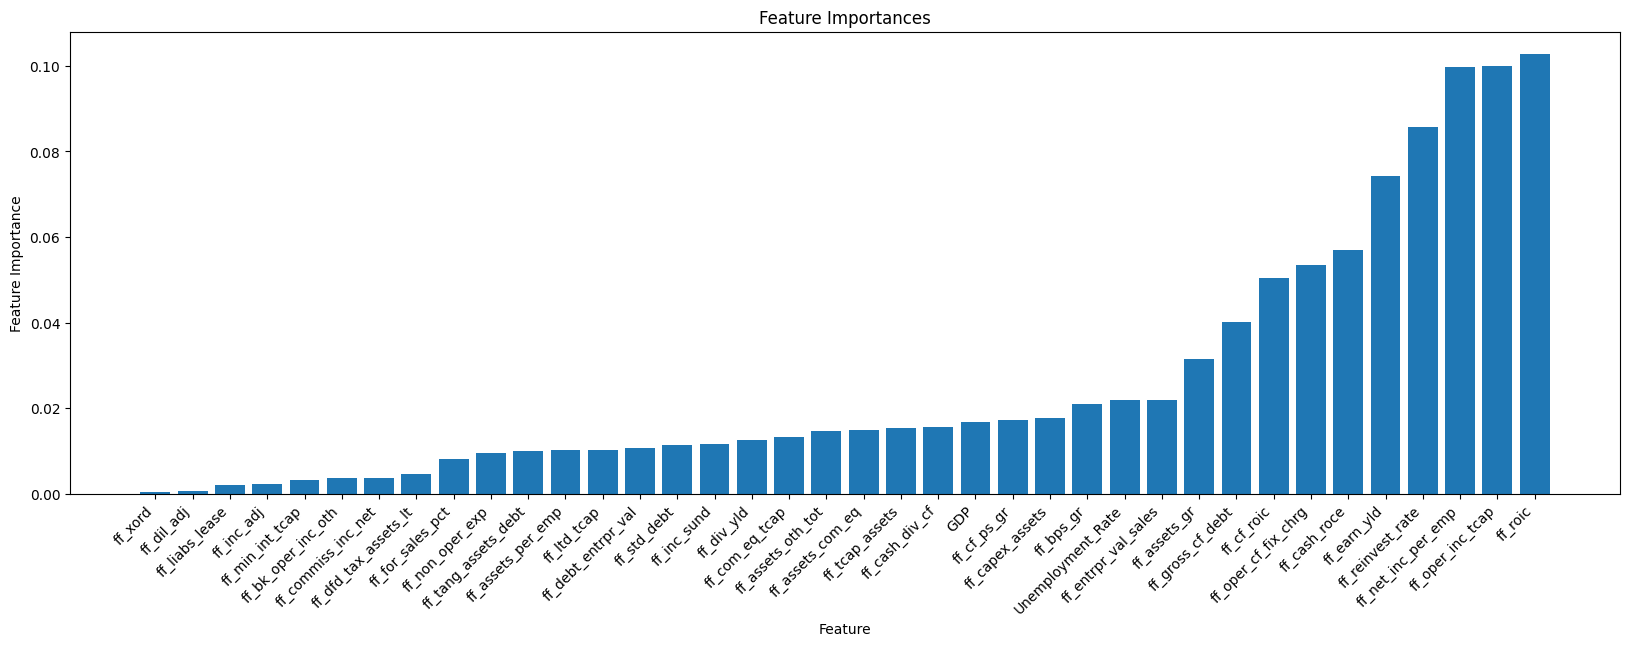

In [25]:
feats_to_drop = feature_importances(model,feats)
# print(feats_to_drop)
# df2 = df.drop(*feats_to_drop)
# model2, feats2, X_train2 = model_testing(df2, 'XGB')

In [ ]:
_ = feature_importances(model2,feats2)

In [ ]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    tscv = TimeSeriesSplit(n_splits=5)
    seed = 42
    df=df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    X_train = df.drop(exclude_columns, axis=1)
    Y_train = df['label']
    
    features = X_train.columns[:-1]
    print(len(features))
    
    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        num_pos = len(y_train[y_train == 1])
        print(num_pos/len(y_train))
        isol_for = IsolationForest(contamination=num_pos/len(y_train), random_state=42)

        isol_for.fit(x_train[features])

        train_df = x_train.copy()  # Create a copy of the training set for results
        test_df = x_test.copy()    # Create a copy of the test set for results

        train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
        train_df['anomaly'] = isol_for.predict(train_df[features])
        train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

        test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
        test_df['anomaly'] = isol_for.predict(test_df[features])
        test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)

        print(f"Classification Report: ")
        print(classification_report(y_test, test_df['preds']))
        # cm = confusion_matrix(y_test, test_df['preds'])
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        
   
    
    
    
# anomaly_det(df2)

In [ ]:
def shapley(model, train, test):
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer(train)
    shap.initjs()
    print(shap_values.shape)
    shap.plots.waterfall(shap_values[0])
    
shapley(model2, X_train2, None)

In [ ]:

from sklearn.svm import OneClassSVM


def anomaly_det2(df):
    tscv = TimeSeriesSplit(n_splits=5)
    
    df = df.toPandas()
    print("Converted to Pandas")

    exclude_columns = ['fsym_id']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    X_train = df.drop(exclude_columns, axis=1)
    Y_train = df['label']
    
    features = X_train.columns[:-1]

    for train_index, test_index in tscv.split(X_train):
        x_train, x_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        num_pos = len(y_train[y_train == 1])
        clf = OneClassSVM(nu=num_pos/len(y_train))  # Adjust the nu parameter
        clf.fit(x_train[features])

        train_df = x_train.copy()
        test_df = x_test.copy()

        train_df['anomaly_scores'] = clf.decision_function(train_df[features])
        train_df['preds'] = np.where(train_df['anomaly_scores'] < 0, -1, 1)

        test_df['anomaly_scores'] = clf.decision_function(test_df[features])
        test_df['preds'] = np.where(test_df['anomaly_scores'] < 0, -1, 1)
        
        print(f"Classification Report: ")
        print(classification_report(y_test, np.where(test_df['preds'] == -1, 1, 0)))
        cm = confusion_matrix(y_test, np.where(test_df['preds'] == -1, 1, 0))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

# Call the function with your data
# anomaly_det2(df2)

In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
# gbt_feats = boruta_fs(df, 'gbt')

### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()